In [3]:
import numpy as np
import tensorflow as tf

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import utils

import os
from os.path import join as pjoin
import sys
import copy

import models.nn4 as network

In [4]:
FLAGS = utils.load_tf_flags()
tf.Graph().as_default()
sess = tf.Session()
images_placeholder = tf.placeholder(tf.float32, shape=(FLAGS.batch_size, FLAGS.image_size, FLAGS.image_size, 3), name='input')
phase_train_placeholder = tf.placeholder(tf.bool, name='phase_train')
embeddings = network.inference(images_placeholder, FLAGS.pool_type, FLAGS.use_lrn, 1.0, phase_train=phase_train_placeholder)
ema = tf.train.ExponentialMovingAverage(1.0)
saver = tf.train.Saver(ema.variables_to_restore())
ckpt = tf.train.get_checkpoint_state(os.path.expanduser(FLAGS.model_dir))
saver.restore(sess, ckpt.model_checkpoint_path)

name =  incept3a
inputSize =  192
kernelSize = {3,5}
kernelStride = {1,1}
outputSize = {128,32}
reduceSize = {96,16,32,64}
pooling = {MAX, 3, 3, 1, 1}
outputSize =  256

name =  incept3b
inputSize =  256
kernelSize = {3,5}
kernelStride = {1,1}
outputSize = {128,64}
reduceSize = {96,32,64,64}
pooling = {MAX, 3, 3, 1, 1}
outputSize =  320

name =  incept3c
inputSize =  320
kernelSize = {3,5}
kernelStride = {2,2}
outputSize = {256,64}
reduceSize = {128,32,0,0}
pooling = {MAX, 3, 3, 2, 2}
outputSize =  640

name =  incept4a
inputSize =  640
kernelSize = {3,5}
kernelStride = {1,1}
outputSize = {192,64}
reduceSize = {96,32,128,256}
pooling = {MAX, 3, 3, 1, 1}
outputSize =  640

name =  incept4b
inputSize =  640
kernelSize = {3,5}
kernelStride = {1,1}
outputSize = {224,64}
reduceSize = {112,32,128,224}
pooling = {MAX, 3, 3, 1, 1}
outputSize =  640

name =  incept4c
inputSize =  640
kernelSize = {3,5}
kernelStride = {1,1}
outputSize = {256,64}
reduceSize = {128,32,128,192}
pooling = {MAX, 3, 3

In [7]:
def load_data(data_dir):
    data = {}
    pics_ctr = 0
    for guy in os.listdir(data_dir):
        person_dir = pjoin(data_dir, guy)
        curr_pics = [utils.preproc(cv2.imread(pjoin(person_dir, f))) for f in os.listdir(person_dir)]
        if len(curr_pics) < 2 or np.random.random() > 0.5:
            continue
        if pics_ctr > 100:
            break
        data[guy] = curr_pics
        pics_ctr += len(curr_pics)
    return data, pics_ctr

Loaded 102 pics.
Random guy from LFW dataset


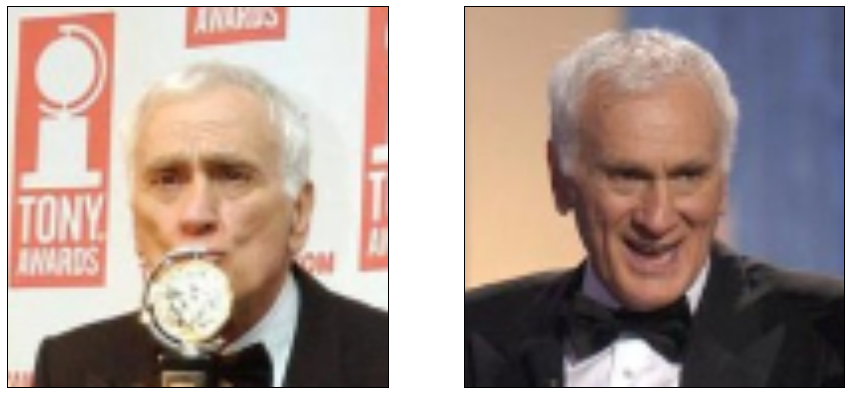

In [14]:
DATA_DIR = '/home/loe/dev/yobiface/data/lfw'
data, n_pics = load_data(DATA_DIR)

print('Loaded %d pics.' % n_pics)

# load random guy and show his pics
random_guy = np.random.choice(list(data.keys()))

fig = plt.figure()
print('Random guy from LFW dataset')
fig.set_figheight(15)
fig.set_figwidth(15)
for i, pic in enumerate(data[random_guy]):
    utils.imshow(fig, pic, 1, len(data[random_guy]), i+1)

In [15]:
#initialize embeddings dict
emb_dict = {}
for guy in data:
    emb_dict[guy] = list(sess.run([embeddings], feed_dict={images_placeholder: np.array(data[guy]), phase_train_placeholder: False })[0])

### test the model

/usr/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


We sample the pic from Paul_Martin.
---------------------------
I think, the pic belongs to Paul_Martin.


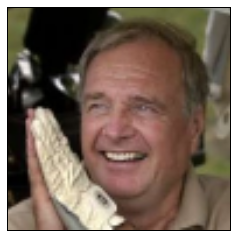

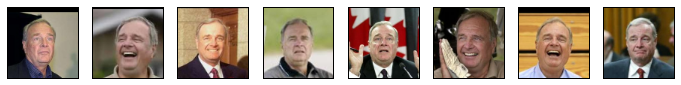

In [37]:
testing_data = copy.deepcopy(data)
testing_emb = copy.deepcopy(emb_dict)

# take random guy to test
guy = np.random.choice(list(testing_data.keys()))

# take random pic of the guy and remove taken pic from the data to avoid cheating
p_ind = np.random.randint(len(testing_data[guy]))
curr_pic = testing_data[guy].pop(p_ind)
curr_emb = emb_dict[guy].pop(p_ind)


#compute mean distance from random pic of the chosen guy to all the guys in the database
min_dist = sys.maxsize

mean_dist = []
for g in testing_data.keys():
    mean_embedding = np.mean(emb_dict[g], axis=0)
    
    # compute dist from guy's pic to mean embedding
    dist = np.linalg.norm(mean_embedding - curr_emb)
    mean_dist.append(dist)
    if min_dist > dist:
        min_dist = dist
        closest_guy = g
    #print('%s\t: %.2f' % (g,dist))

fig1 = plt.figure()
print('We sample the pic from %s.' % guy)
print('---------------------------')
print("I think, the pic belongs to %s." % closest_guy)

utils.imshow(fig1, curr_pic)
fig2 = plt.figure()
fig2.set_figheight(15)
fig2.set_figwidth(15)
# show no more than 10 pics of the guy
n_p = max(len(data[closest_guy]), 10) 
for i, pic in enumerate(data[closest_guy]):
    if i > n_p:
        break
    utils.imshow(fig2, pic, 1, n_p, i+1) 

### t-SNE for 2D representation of embeddings

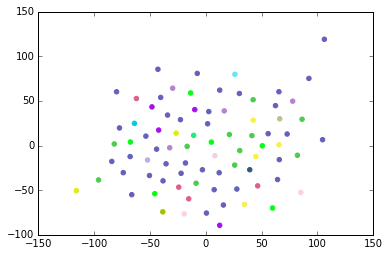

In [38]:
from sklearn.manifold import TSNE
arr = []
cols = []

for guy in emb_dict:
    color = utils.get_random_color()
    for p in emb_dict[guy]:
        arr.append(p)
        cols.append(color)        

model = TSNE(n_components=2, random_state=0, init='pca')
np.set_printoptions(suppress=True)
tsne_res = model.fit_transform(arr) 
plt.scatter(tsne_res[:,0], tsne_res[:,1], color=cols);